In [1]:
# Cargamos las librerías necesarias para la práctica
import tensorflow as tf
import keras
from keras import models
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, Flatten, LeakyReLU, Activation, Dropout, MaxPooling2D,UpSampling2D
from keras.layers import Layer, Reshape, Conv2DTranspose, Lambda, ReLU, BatchNormalization
from keras.metrics import binary_crossentropy
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint 
from livelossplot import PlotLossesKeras
from keras.utils import plot_model
from keras.datasets import mnist, cifar10
from tqdm import tqdm
from io import BytesIO, StringIO
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image

import numpy as np
import cv2

import os, random, re, imageio, time, inspect

# %matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Using TensorFlow backend.


In [2]:
# Esto es solo necesario en el caso de tener varías GPUs en el equipo
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

In [3]:
class Autoencoder:
    
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size, encoder_conv_strides,
                 decoder_conv_filters, decoder_conv_kernel_size, decoder_conv_strides, activation, z_dim,
                 use_batch_normalization=False, dropout = None):
    
        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_filters = decoder_conv_filters
        self.decoder_conv_kernel_size = decoder_conv_kernel_size
        self.decoder_conv_strides = decoder_conv_strides
        self.z_dim = z_dim
        self.activation = activation
        self.use_batch_normalization = use_batch_normalization
        self.dropout = dropout
        
        # Esta parte está modificada para enlazar el codificador y el decodificador
        self.encoder, encoder_input, encoder_output = self.__create_encoder() 
        self.decoder = self.__create_decoder()
        self.model = Model(encoder_input, self.decoder(encoder_output))
        
    def __create_encoder(self):

        encoder_input = Input(shape=self.input_dim, name='encoder_input') 
        x = encoder_input
        for i in range(len(self.encoder_conv_filters)):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i],
                kernel_size = self.encoder_conv_kernel_size[i],
                strides = self.encoder_conv_strides[i],
                padding = 'same',
                activation = self.activation if isinstance(self.activation, str) else None,
                name = 'encoder_conv_' + str(i)
            )
 
            x = conv_layer(x)
            
            # Si el usuario ha definido una función de activación específica
            # para la última capa la ponemos. Para ver si la ha definido o no usamos
            # inspect. Más información en https://docs.python.org/3/library/inspect.html   
            if inspect.isclass(self.activation) and Layer in self.activation.__bases__:
                x = self.activation()(x)
            # Si el usuario ha marcado el uso de BatchNormalization, lo incluimos    
            if self.use_batch_normalization:
                x = BatchNormalization()(x)
            # Si hay Dropout, lo incluimos
            if self.dropout:
                x = Dropout(self.dropout)(x)                

        # Nos guardamos el tamaño antes de aplanar y aplanamos        
        self.__shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)
        
        encoder_output = self._create_latent_vector(encoder_input, x)
        
        return Model(encoder_input, encoder_output), encoder_input, encoder_output #(5)
        
    def _create_latent_vector(self, encoder_input, x):
        encoder_output= Dense(self.z_dim, name='encoder_output')(x) 
        return encoder_output
    
    
    def __create_decoder(self):
        # La entrada del decodificador es un vector del tamaño
        # que hayamos fijado para el vector latente
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')
        # Conectamos la entrada a una capa densa con tantas neuronas como
        # entradas tenía la capa correspondiente en el codificador antes de aplanar
        x = Dense(np.prod(self.__shape_before_flattening))(decoder_input)
        # Cambiamos el tamaño de la salida de la capa densa y lo adaptamos 
        # para ser la entrada 2Dde una capa convolutiva
        
        x = Reshape(self.__shape_before_flattening)(x) #(3)
        # Creamos las capas Conv2DTranspose y las apilamos
        for i in range(len(self.decoder_conv_filters)):
            activation = self.activation if isinstance(self.activation, str) else None
            conv_layer = Conv2DTranspose(
                filters = self.decoder_conv_filters[i],
                kernel_size = self.decoder_conv_kernel_size[i],
                strides = self.decoder_conv_strides[i],
                padding = 'same',
                activation = activation if i < len(self.decoder_conv_filters)-1 else 'sigmoid',
                name = 'decoder_conv_' + str(i)
            )
 
            x = conv_layer(x) 
            # De manera análoga a lo que ocurría en el codificador, hacemos las
            # comprobaciones y los cambios si son necesarios
            if i < len(self.decoder_conv_filters)-1:
                if inspect.isclass(self.activation) and Layer in self.activation.__bases__:
                    x = self.activation()(x)

                if self.use_batch_normalization:
                    x = BatchNormalization()(x)

                if self.dropout:
                    x = Dropout(self.dropout)(x)                
            
            
        decoder_output = x
        # Finalmente, devolvemos el decodificador que toma como entrada
        # el vector latente y devuelve una imagen del mismo tamaño que las imágenes de entrada
        return Model(decoder_input, decoder_output)

In [4]:
def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

In [5]:
def kl_reconstruction_loss(true, pred):
  # Reconstruction loss
  reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * mi_lado * mi_lado
  # KL divergence loss
  kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
  kl_loss = K.sum(kl_loss, axis=-1)
  kl_loss *= -0.5
  # Los coeficientes aparecen en la siguiente linea.
  # Prueba a cambiarlos.
  return K.mean(0.2 * reconstruction_loss + 0.8 * kl_loss)

In [6]:
class VariationalAutoencoder(Autoencoder):
    
    def _create_latent_vector(self, encoder_input, x):
        # En vez de conectar directamente el vector aplanado al espacio latente 
        # se conecta a dos capas densas representante de mu y sigma.
        # Cada una de estas capas tiene tantas neuronas como indique z_dim,
        # esto es, tantas como indique la dimensión del espacio latente
        # Guardamos las capas en atributos de la clase porque nos hará falta 
        # para computar la función de coste. 
        self._mu = Dense(self.z_dim, name='mu')(x)                                          
        self._log_var = Dense(self.z_dim, name='log_var')(x)
        # Creamos un modelo auxiliar que nos servirá para obtener mu y sigma 
        # a partir de una imagen de entrada.
        self._encoder_mu_log_var = Model(encoder_input, (self._mu, self._log_var))    #(2)
        # Creamos la función sampling
        def sampling(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
            return mu + K.exp(log_var / 2) * epsilon
        # Definimos una capa Lambda para usar la función sampling y muestrear
        # las capas self._mu y self._log_var donde codificamos la distribución de
        # probabilidad definida por mu y sigma.
        encoder_output = Lambda(sampling, name='encoder_output')([self._mu, self._log_var])   #(3)

        # La salida es un par de valores. El primero se elige entre las salidas 
        # de las z_dim neuronas de la capa densa self._mu y el segundo se elige 
        # entre las z_dim neuronas de la capa densa self._log_var. La probabilidad de elegir
        # una u otra neurona no es uniforme, sino que sigue la distribución normal 
        # marcada por mu y sigma.
        return encoder_output

In [7]:
def mse(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

def bin_crossentropy(y_true, y_pred):
    return K.mean(binary_crossentropy(y_true, y_pred))

def ssim(y_true, y_pred):
    return 1 - K.mean(ssim_loss(y_true, y_pred))

def ssim_loss(y_true, y_pred):
  return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

class KL_loss:
    
    def __init__(self, mu, log_var):
        self.mu = mu
        self.log_var = log_var
        self.__name__ = 'kl_loss'
        
    def __call__(self, y_true, y_pred):
        return -0.5 * K.sum(1 + self.log_var - 
                            K.square(self.mu) - 
                            K.exp(self.log_var), axis = 1)
        
class VAELoss:
    
    def __init__(self, eta1, eta2, mu, log_var, base_metric=mse):
        self.eta1 = eta1
        self.eta2 = eta2
        self.base_metric = base_metric
        self.__kl_loss = KL_loss(mu, log_var)
        self.__name__ = 'vae_loss'

        
    def __call__(self, y_true, y_pred):
        return self.eta1 * self.base_metric(y_true, y_pred) + self.eta2 * self.__kl_loss(y_true, y_pred)

In [9]:
INPUT_DIM = (64, 64, 3)

VAE_CELEBA = VariationalAutoencoder(
                        input_dim = INPUT_DIM
                        , encoder_conv_filters=[32,64,64, 64]
                        , encoder_conv_kernel_size=[3,3,3,3]
                        , encoder_conv_strides=[2,2,2,2]
                        , decoder_conv_filters=[64,64,32,3]
                        , decoder_conv_kernel_size=[3,3,3,3]
                        , decoder_conv_strides=[2,2,2,2]
                        , activation = ReLU
                        , z_dim=200
                        , use_batch_normalization=True
                        , dropout=0.25)

VAE_CELEBA.model.compile(optimizer=Adam(0.0005), 
                           loss=VAELoss(1, 1/10000, VAE_CELEBA._mu, 
                                        VAE_CELEBA._log_var, base_metric=mse), 
                           metrics=[ssim_loss, mse, KL_loss(VAE_CELEBA._mu, VAE_CELEBA._log_var)])

In [13]:
VAE_CELEBA.model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 32, 32, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 32, 32, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 32)   128         re_lu_1[0][0]                    
____________________________________________________________________________________________

In [60]:
# Ruta en el ordenador de David
# DATA_FOLDER = '/home/dasolma/data/celeba'

# Ruta en el ordenador de Miguel
DATA_FOLDER = 'C:/Users/Sergio Valdivia/Desktop/CelebA_resized'

IMG_FOLDER = os.path.join(DATA_FOLDER, 'celebA')
att_file = os.path.join(DATA_FOLDER, 'list_attr_celeba.csv')

# obtenemos los nombres de los archivos de imágenes
file_names = os.listdir(IMG_FOLDER)

print('Total de imagenes: %d' % len(file_names))

Total de imagenes: 202599


In [61]:
X = [open(os.path.join(DATA_FOLDER, 'celebA', f), 'rb').read() for f in tqdm(file_names)]


  3%|▎         | 5106/202599 [00:41<32:37, 100.91it/s]


  6%|▌         | 11816/202599 [01:21<14:40, 216.60it/s]


 10%|▉         | 19368/202599 [02:02<43:24, 70.35it/s]


 13%|█▎        | 27206/202599 [02:45<21:15, 137.53it/s]


 19%|█▉        | 38814/202599 [03:26<06:58, 391.33it/s]


 27%|██▋       | 53716/202599 [04:10<06:14, 397.13it/s]


 31%|███▏      | 63577/202599 [04:50<04:49, 480.74it/s]


 39%|███▊      | 78463/202599 [05:33<12:44, 162.27it/s]


 46%|████▋     | 93776/202599 [06:19<04:15, 425.99it/s]


 53%|█████▎    | 107963/202599 [07:00<16:29, 95.61it/s]


 59%|█████▉    | 120140/202599 [07:44<06:08, 223.69it/s]


 66%|██████▌   | 133366/202599 [08:26<07:15, 158.98it/s]


 72%|███████▏  | 145334/202599 [09:12<03:11, 299.33it/s]


 76%|███████▌  | 154300/202599 [10:11<12:01, 66.92it/s]


 81%|████████  | 163915/202599 [11:06<05:27, 118.22it/s]


 84%|████████▍ | 170777/202599 [12:01<04:02, 131.27it/s]


 89%|████████▉ | 180665/202599 [12:43<03:06, 117.48it/s]


 94%|█████████▎| 189622/202599 [13:23<01:11, 181.52it/s]


 99%|█████████▉| 200724/202599 [14:04<00:10, 173.11it/s]


100%|██████████| 202599/202599 [14:12<00:00, 237.79it/s]

In [62]:
t_principio = time.time()
for im in tqdm(X):
    b = BytesIO(im)
    file_bytes = np.asarray(bytearray(BytesIO(im).read()), dtype=np.uint8)
    im = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
t_final = time.time()
print('Esta operación ha tardado',t_final - t_principio,'segundos')


100%|██████████| 202599/202599 [00:23<00:00, 8517.10it/s]

Esta operación ha tardado 23.802945852279663 segundos


In [63]:
class CelebaInMemoryIterator(keras.utils.Sequence):
       
    def __init__(self, im_bytes, batch_size, shuffle=True):
        self.im_bytes = im_bytes
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.__len = int(len(self.im_bytes) / self.batch_size)
        
        self.reset()

    def __len__(self):
        return self.__len

    def __getitem__(self, index):
        # comienzo y final del batch
        i = index * self.batch_size
        j = i + self.batch_size
        
        # indixes del batch
        indexes = self.__indexes[i:j]
        
        # imagenes binarias del batch
        batch = [self.im_bytes[k] for k in indexes]

        # lista final de arrays
        ims = []
   
        # convertimos a numpy arrays
        for im in batch:
            b = BytesIO(im)
            file_bytes = np.asarray(bytearray(BytesIO(im).read()), dtype=np.uint8)
            im = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            im = cv2.resize(im, (64, 64)) 
            ims.append(im)

        # escalamos a valores entre 0 y 1
        ims = np.array(ims).astype('float') / 255
        
        
        return ims, ims


    def on_eponch_end(self):
        self.reset()
        
    def reset(self):
        self.__indexes = list(range(len(self.im_bytes)))           
        if self.shuffle:
            self.__indexes = random.sample(self.__indexes, len(self.__indexes))
        self.__current_index = 0

    def __iter__(self):
        return self

    def __next__(self, *args, **kwargs):
        # si hemos llegado al final reiniciamos
        if self.__current_index >= self.__len:
            self.reset()
            
        # cogemos el siguiente batch
        r =  self.__getitem__(self.__current_index)
        
        # incrementamos el indice
        self.__current_index += 1
        
        
        return r

In [64]:
INPUT_DIM = (64,64,3)
BATCH_SIZE = 128

# dividimos el conjunto de datos entrenamiento y test
indexes = list(range(len(X)))
random.shuffle(indexes)
cut_point = int(len(X) * 0.7)
X_train = [X[i] for i in indexes[:cut_point]]
X_test = [X[i] for i in indexes[cut_point:]]    

# creamos los iteradores
train_generator = CelebaInMemoryIterator(X_train, 32)
test_generator = CelebaInMemoryIterator(X_test, 128)

In [89]:

mi_checkpoint = ModelCheckpoint('vae_celeba_pesos.h5', 
                                save_weights_only=True,
                                monitor='val_loss', 
                                save_best_only=True)

mi_earlystopping = EarlyStopping(monitor='val_loss', 
                                 mode='min', 
                                 patience=5)

mi_callbacks = [PlotLossesKeras(),mi_checkpoint,mi_earlystopping]




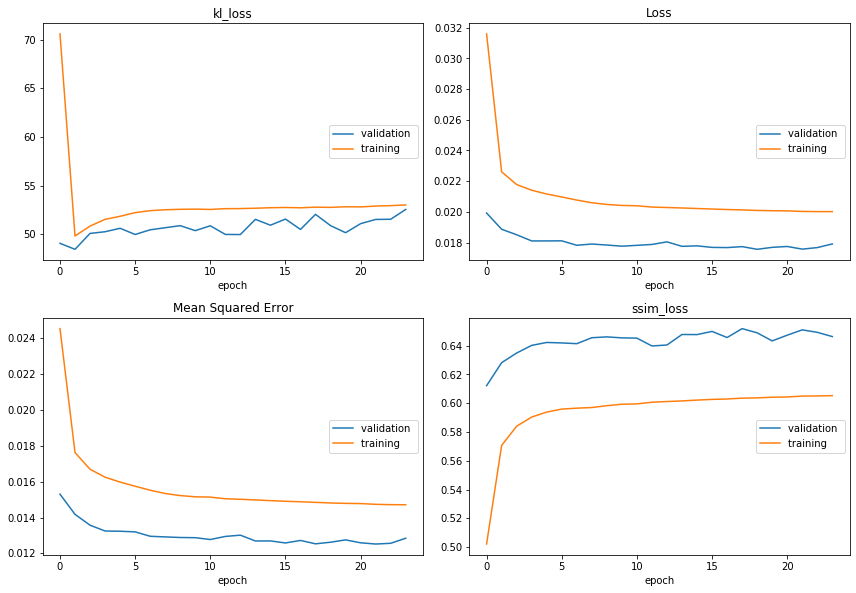

kl_loss
	validation       	 (min:   48.467, max:   52.560, cur:   52.560)
	training         	 (min:   49.832, max:   70.591, cur:   53.022)
Loss
	validation       	 (min:    0.018, max:    0.020, cur:    0.018)
	training         	 (min:    0.020, max:    0.032, cur:    0.020)
Mean Squared Error
	validation       	 (min:    0.013, max:    0.015, cur:    0.013)
	training         	 (min:    0.015, max:    0.025, cur:    0.015)
ssim_loss
	validation       	 (min:    0.612, max:    0.652, cur:    0.646)
	training         	 (min:    0.502, max:    0.605, cur:    0.605)


In [90]:
VAE_CELEBA.model.fit_generator(train_generator, validation_data=test_generator,epochs = 50, callbacks=mi_callbacks)

In [92]:
VAE_CELEBA.model.load_weights('vae_celeba_pesos.h5')

In [94]:
def draw2compare(*args):
    n = len(args[0])
    plt.figure(figsize=(20, 2*len(args)))
    for i in range(n):
        for j in range(len(args)):
            img = args[j][i]
            ax = plt.subplot(len(args), n, i + 1 + j*n)
            if len(img.shape) == 3 and img.shape[2] == 1:
                plt.imshow(img.reshape(img.shape[:2]))
            else:
                plt.imshow(img)

            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

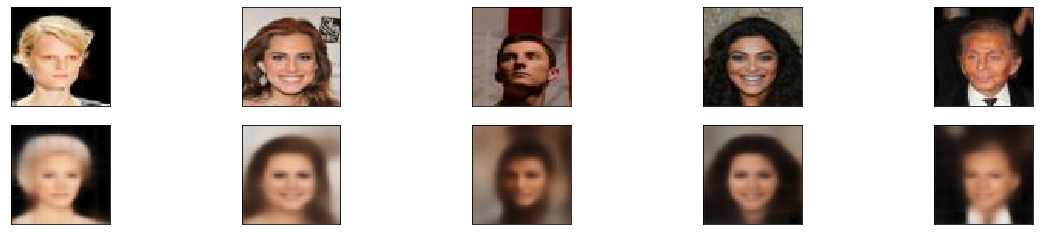

In [109]:
predict_generator = CelebaInMemoryIterator(X_test[:30], 5, shuffle=True)
x, _ = predict_generator.__next__()
draw2compare(x, VAE_CELEBA.model.predict(x))

In [110]:
rows = 3
cols = 10
y = tuple([VAE_CELEBA.decoder.predict(np.random.normal(size=(cols, VAE_CELEBA.z_dim))) for _ in range(rows)])
#len(y), len(y[0]

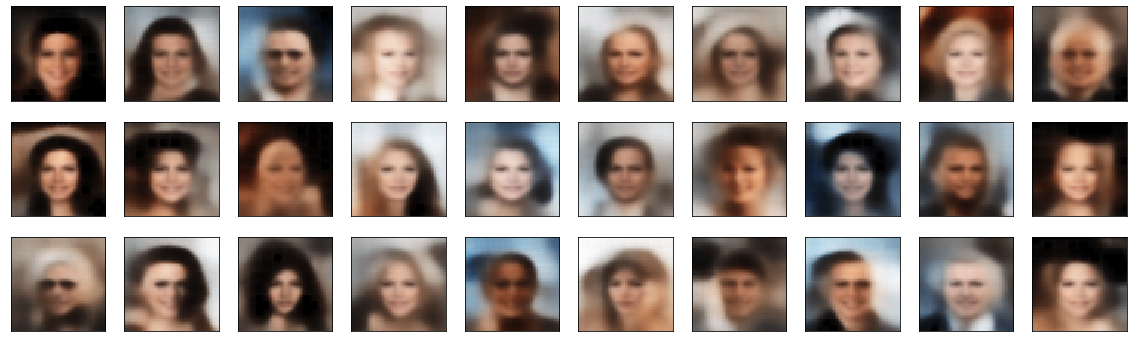

In [111]:
draw2compare(*y)